# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 2 - Unsupervised Deep Learning

## General overview: 

In this homework you will learn how to implement and test neural network models for 
solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen 
before, the homework will be based on images of FashionMNIST. However, you can optionally explore 
different image collections (e.g., Caltech or Cifar) or other datasets based on your interests. The basic tasks
for the homework will require to test and analyze the convolutional autoencoder implemented during the 
Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar 
performance considering the relatively small size of the FashionMNIST images. As for the previous 
homework, you should explore the use of advanced optimizers and regularization methods. Learning 
hyperparameters should be tuned using appropriate search procedures, and final accuracy should be 
evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and 
variational / adversarial architectures.


In [107]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import random 

import os

import torch
import torchvision
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, SequentialSampler, ConcatDataset
from torchvision import transforms
from torch.autograd import Variable
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm   
from scipy.stats import loguniform 
from IPython.display import clear_output

# Dataset

## Define the dataset

The Fashion MNIST dataset is a colletion of Zalando's article images. The size of the images is $28 \times 28$, and there is a single channel only (black and white images) with 10 classes.

In [108]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

Let's plot some random samples from the dataset. The first element of the sample is the actual image, while the second is the corresponding label.

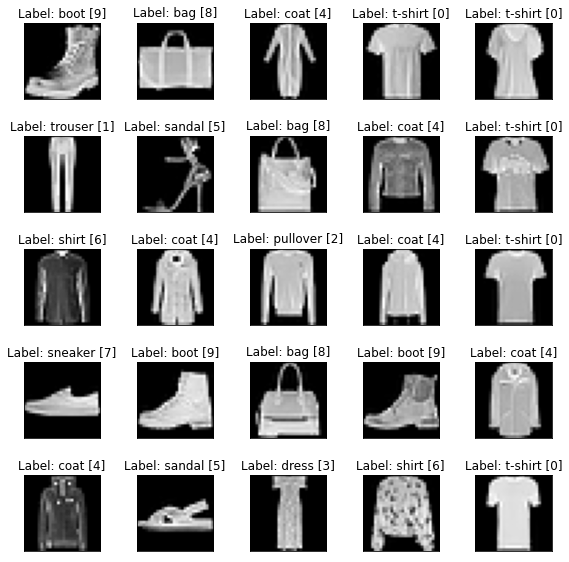

In [109]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

In this example we are using the input images without any modification. As always, the only requirement is to transform the input data to tensors of the proper shape.

In [110]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


In [111]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## Define the dataloader

The dataloader allows to easily create batch of data, in this case we set a batch size of 256, and we also enable data shuffling for the training dataset.

In [112]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [113]:
class Encoder(nn.Module):

  def __init__(self, encoded_space_dim, n_channels):

      super().__init__()

      #Convolutional layers
      self.encoder_cnn = nn.Sequential(
          #first layer

          
            #conv
            #(input-kernel+2*padding)/stride + 1


          #img size = (28-3+2*1)/2 + 1 = 14x14
          nn.Conv2d(in_channels = 1, out_channels = n_channels, kernel_size = 3, stride = 2, padding = 1),
          nn.ReLU(),
          #second layer
          #img size = (14-3)/2 +1 = 6x6
          nn.Conv2d(in_channels = n_channels, out_channels = 2*n_channels, kernel_size = 3, stride = 2),
          nn.ReLU(),
          #third layer 
          #img size = 6-3+1 = 4x4
          nn.Conv2d(in_channels = 2*n_channels, out_channels = 3*n_channels, kernel_size = 3),
          nn.ReLU()
      )

      #flatten layer
      self.flatten = nn.Flatten(start_dim=1)

      #linear layers
      self.encoder_lin = nn.Sequential(
        #input = (image size)*(3*n_channels)=4x4x3 = 48
        nn.Linear(48*n_channels, 64), #random number
        nn.ReLU(),
        #second linear layer to output
        nn.Linear(64, encoded_space_dim)
      )
        
  def forward(self, x):
    # Apply convolutions
    x = self.encoder_cnn(x)
    # Flatten
    x = self.flatten(x)
    # Apply linear layers
    x = self.encoder_lin(x)
    return x

In [114]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, n_channels):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=48*n_channels),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(3*n_channels, 4, 4))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            #4-1+3 = 6 x 6
            nn.ConvTranspose2d(in_channels=3*n_channels, out_channels=2*n_channels, kernel_size=3),
            nn.ReLU(True),
            # Second transposed convolution
            #deconv
            #stride(input-1)+kernel-2*padding
            #2(6-1)+3= 13 x 13
            nn.ConvTranspose2d(in_channels=2*n_channels, out_channels=n_channels, kernel_size=3, 
                               stride=2),
            nn.ReLU(True),
            # Third transposed convolution
            #2(13-1)+5-2*1+1 = 28
            nn.ConvTranspose2d(in_channels=n_channels, out_channels=1, kernel_size=5, 
                               stride=2, padding=1, output_padding=1)
        )
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [115]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 5
n_channels = 8
encoder = Encoder(encoded_space_dim=encoded_space_dim, n_channels = n_channels)
decoder = Decoder(encoded_space_dim=encoded_space_dim, n_channels = n_channels)

In [116]:
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 5])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [117]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
print(encoder.to(device))
decoder.to(device)

Selected device: cpu
Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=384, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
)


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=384, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(24, 4, 4))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(24, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Training function

For a cleaner and more reusable code, we define a training and a testing funcion. This will make the training loop more compact and readable.

The function will train (and test) the network just **for a single epoch**.

In this case, we just track the training loss for each batch. If you want the training loss for the entire epoch, you have to concatenate all the outputs (see the testing function as reference for this case).

In [118]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    train_losses = []
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
         #print('\t partial train loss (single batch): %f' % (loss.data))
        train_losses.append(loss.data)
    train_loss = np.mean(train_losses)
    return train_loss

## Testing function

In this case, the testing function has the only goal to evaluate how well we are reproducing the input. We quantify this with the average MSE of the entire test set (which in this case correspond to our loss function, but this is not always true).

Since the entire dataset does not always fit in memory, this example shows how to evaluate the network output in batches, aggregating the results (using `conc_out` and `conc_label` in the code). At the end, you can evaluate a  single overall loss.

In [119]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Training loop

Now that we have the training and testing functions, the training loop is considerably simplified. We just need to call these 2 functions for `num_epochs` times.

To see what happen during the training, we also show the output corresponding to a specific image at the end of each epoch.

In [120]:
def training_func(encoder, decoder, loss_fn, params_dict, training_loader, testing_loader, testing_set, verbose = True, plot = True, save = True, save_plot_prog = True):  ### Training cycle

  optim = params_dict.get('optimizer')
  device = params_dict.get('device')
  num_epochs = params_dict.get('num_epochs')

  val_losses = []
  train_losses = []
  
  imgs = []


  for epoch in range(num_epochs):
      ### Training (use the training function)
      train_loss = train_epoch(
          encoder=encoder, 
          decoder=decoder, 
          device=device, 
          dataloader=training_loader, 
          loss_fn=loss_fn, 
          optimizer=optim)
      ### Validation  (use the testing function)
      val_loss = test_epoch(
          encoder=encoder, 
          decoder=decoder, 
          device=device, 
          dataloader=testing_loader, 
          loss_fn=loss_fn)
      # Print Validationloss      
      if verbose:
          print('EPOCH %d/%d' % (epoch + 1, num_epochs))
          print('\t VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss))

      val_losses.append(val_loss)
      train_losses.append(train_loss)

      if plot:
        img = testing_set[0][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        plt.show()
        plt.close()

      if save_plot_prog:
        img = test_dataset[0][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        plt.title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        # Save figures
        os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        plt.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
        plt.show()
        plt.close()
        imgs.append(rec_img.cpu().squeeze().numpy())


      if save:
        torch.save(encoder_best.state_dict(), 'encoder_params.pth')
        torch.save(decoder_best.state_dict(), 'decoder_params.pth')

  return train_losses, val_losses, imgs

In [121]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

params = dict({'optimizer': optim,
               'num_epochs': 20,
               'device': device})

Selected device: cpu


EPOCH 1/20
	 VALIDATION - EPOCH 1/20 - loss: 0.048530


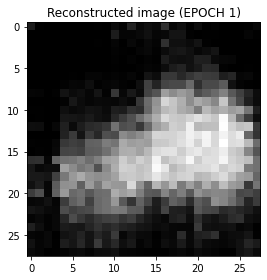

EPOCH 2/20
	 VALIDATION - EPOCH 2/20 - loss: 0.031987


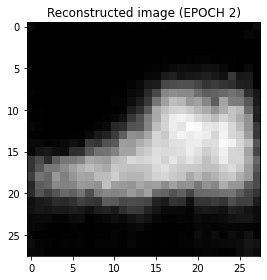

EPOCH 3/20
	 VALIDATION - EPOCH 3/20 - loss: 0.027256


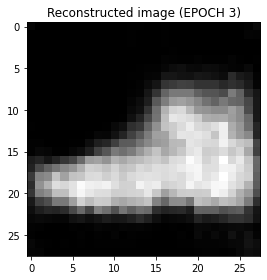

EPOCH 4/20
	 VALIDATION - EPOCH 4/20 - loss: 0.025459


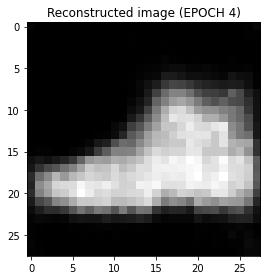

EPOCH 5/20
	 VALIDATION - EPOCH 5/20 - loss: 0.024580


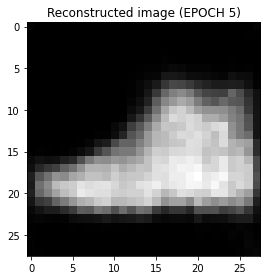

EPOCH 6/20
	 VALIDATION - EPOCH 6/20 - loss: 0.024004


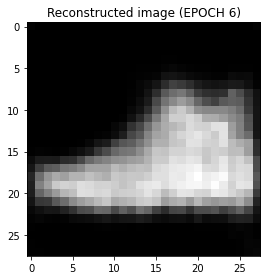

EPOCH 7/20
	 VALIDATION - EPOCH 7/20 - loss: 0.023684


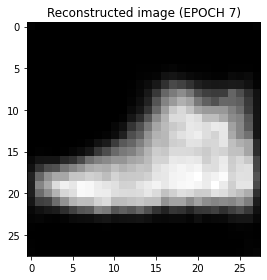

EPOCH 8/20
	 VALIDATION - EPOCH 8/20 - loss: 0.023320


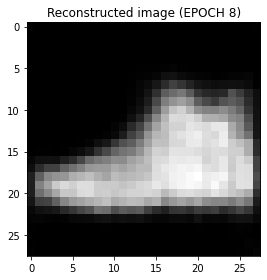

EPOCH 9/20
	 VALIDATION - EPOCH 9/20 - loss: 0.022971


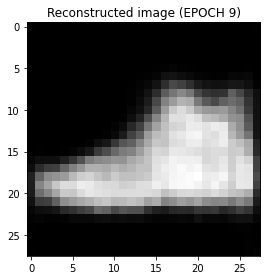

EPOCH 10/20
	 VALIDATION - EPOCH 10/20 - loss: 0.022751


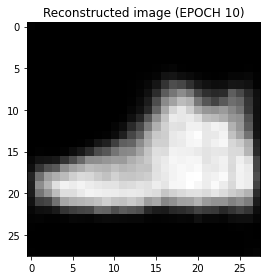

EPOCH 11/20
	 VALIDATION - EPOCH 11/20 - loss: 0.022623


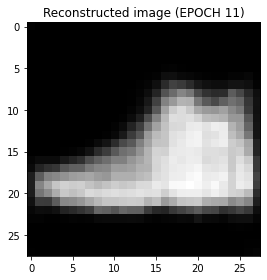

EPOCH 12/20
	 VALIDATION - EPOCH 12/20 - loss: 0.022286


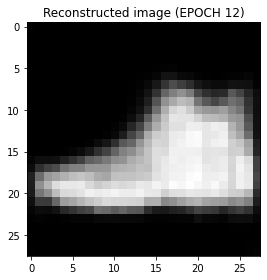

EPOCH 13/20
	 VALIDATION - EPOCH 13/20 - loss: 0.022103


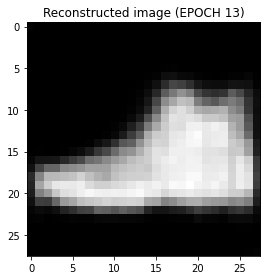

EPOCH 14/20
	 VALIDATION - EPOCH 14/20 - loss: 0.022071


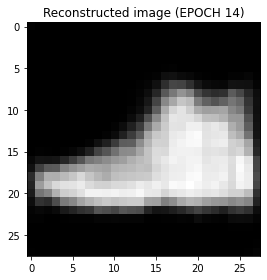

EPOCH 15/20
	 VALIDATION - EPOCH 15/20 - loss: 0.021793


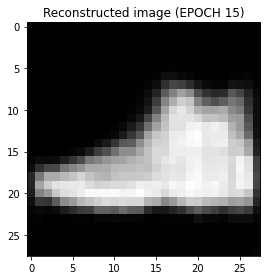

EPOCH 16/20
	 VALIDATION - EPOCH 16/20 - loss: 0.021633


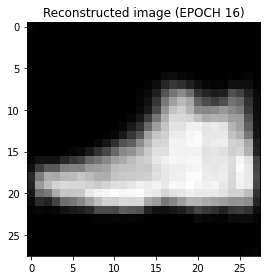

EPOCH 17/20
	 VALIDATION - EPOCH 17/20 - loss: 0.021443


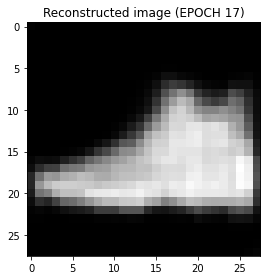

EPOCH 18/20
	 VALIDATION - EPOCH 18/20 - loss: 0.021288


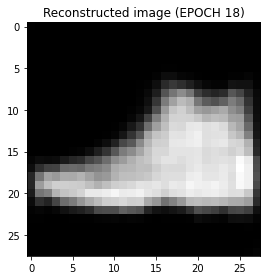

EPOCH 19/20
	 VALIDATION - EPOCH 19/20 - loss: 0.021243


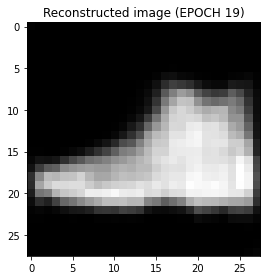

EPOCH 20/20
	 VALIDATION - EPOCH 20/20 - loss: 0.020985


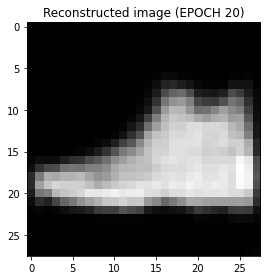

In [122]:
train_losses, val_losses, imgs = training_func(encoder, decoder, loss_fn, params, train_dataloader, test_dataloader, test_dataset, verbose = True, plot = False, save = False, save_plot_prog = True)

In [ ]:
#!rm -rf autoencoder_progress_5_features

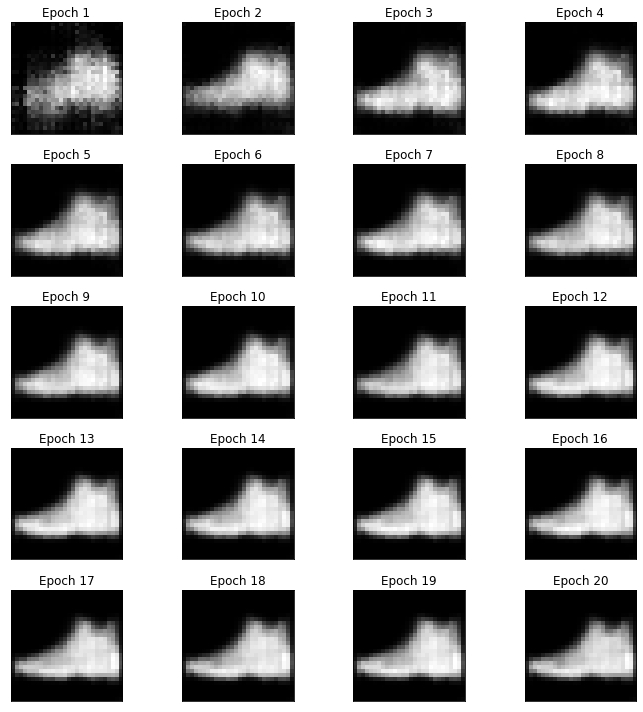

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize = (10, 10))
for i, ax in enumerate(ax.flatten()):
    img = imgs[i]
    ax.imshow(img, cmap='gist_gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Epoch "+str(i+1))
plt.tight_layout()
plt.show()

The network functions quite well. 

Now we have to find the best hyperparameters for the model. 

## Searching for the best set of learning hyperparameters

In [89]:
#loop through sampled random networks

parameters_dict = {
    'encoded_space_dim' : np.random.randint(2,15, size = 100),
    'n_channels' : [5,6,7,8,9,10,11,12],
    'optimizer'  : ['adam', 'sgd'],
    'lr'         : [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01],
    'n_epochs'   : [30],
    'w_decay'    : [0.000001,0.00001,0.0001,0.001,0.01]

}
#sample a single set of parameters out
def sample_set_params(params_all):
  selection = {}
  for param in params_all.keys():
    selection[param] = np.random.choice(params_all.get(param) )

  return selection

sample = sample_set_params(parameters_dict)
sample

{'encoded_space_dim': 11,
 'n_channels': 10,
 'optimizer': 'adam',
 'lr': 0.01,
 'n_epochs': 30,
 'w_decay': 0.01}

In [24]:
def get_correct_optimizer(model, params_dict):
    learn_r = params_dict.get('lr')
    w_decay = params_dict.get('w_decay')
    
    #instantiate the correct optimizer
    if params_dict.get('optimizer') == 'sgd':
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr = learn_r,
            weight_decay = w_decay
            )

    elif params_dict.get('optimizer') == 'adam':
        optimizer = torch.optim.Adam(
        model.parameters(),
        lr = learn_r,
        weight_decay = w_decay
        )

    return optimizer

In [84]:
#the training over the entire training dataset will take too long so I have split instead the validation set into training and a smaller validation set so that
#the training time is reduced. 
train_points=8000
val_points=2000
train_dataset_s, test_dataset_s = torch.utils.data.random_split(test_dataset, [int(train_points), int(val_points)])
batch_size = 100

train_dataloader_s = DataLoader(train_dataset_s,batch_size = batch_size,shuffle = True,num_workers = 0)
test_dataloader_s = DataLoader(test_dataset_s,batch_size = batch_size,shuffle = False,num_workers = 0)

In [90]:
iterations = 60
parameters_list = []

val_losses_net = []
train_losses_net = []


for iteration in range(iterations):

  #select a model
  actual_params = sample_set_params(parameters_dict)
  parameters_list.append(actual_params)

  n_channels = actual_params.get('n_channels').tolist()
  n_epochs = actual_params.get('n_epochs')
  encoded_space_dim = actual_params.get('encoded_space_dim')

  ### Initialize the two networks
  encoder = Encoder(encoded_space_dim=encoded_space_dim, n_channels = n_channels)
  decoder = Decoder(encoded_space_dim=encoded_space_dim, n_channels = n_channels)
  print("TRIAL NUMBER:", iteration+1, "out of", iterations, )
  print(actual_params)

  optim = get_correct_optimizer(encoder, actual_params)
  optim = get_correct_optimizer(decoder, actual_params)

  params = dict({'optimizer': optim,
               'num_epochs': n_epochs,
               'device': device})

  # Move both the encoder and the decoder to the selected device
  encoder.to(device)
  decoder.to(device)

  val_losses = []
  train_losses = []
  ### Training cycle
  #num_epochs = 20
  train_losses, val_losses, imgs = training_func(encoder, decoder, loss_fn, params, training_loader = train_dataloader_s, testing_loader = test_dataloader_s, testing_set = test_dataset, verbose = False, plot = False, save = False, save_plot_prog = False)

  val_losses_net.append(np.mean(val_losses))
  train_losses_net.append(np.mean(train_losses))
  print("Average Validation Loss over epochs:", val_losses_net[-1])
  print("########################################")

TRIAL NUMBER: 1 out of 60
{'encoded_space_dim': 3, 'n_channels': 12, 'optimizer': 'sgd', 'lr': 1e-05, 'n_epochs': 30, 'w_decay': 1e-05}
Average Validation Loss over epochs: 0.18160717
########################################
TRIAL NUMBER: 2 out of 60
{'encoded_space_dim': 14, 'n_channels': 7, 'optimizer': 'sgd', 'lr': 5e-05, 'n_epochs': 30, 'w_decay': 0.01}
Average Validation Loss over epochs: 0.1883084
########################################
TRIAL NUMBER: 3 out of 60
{'encoded_space_dim': 4, 'n_channels': 8, 'optimizer': 'adam', 'lr': 0.001, 'n_epochs': 30, 'w_decay': 0.001}
Average Validation Loss over epochs: 0.08916395
########################################
TRIAL NUMBER: 4 out of 60
{'encoded_space_dim': 6, 'n_channels': 5, 'optimizer': 'adam', 'lr': 0.01, 'n_epochs': 30, 'w_decay': 0.01}
Average Validation Loss over epochs: 0.12341831
########################################
TRIAL NUMBER: 5 out of 60
{'encoded_space_dim': 3, 'n_channels': 6, 'optimizer': 'sgd', 'lr': 5e-05, 'n_

## The best network

In [92]:
#find min validation loss value in list (best performer)
best_value = min(val_losses_net)

#find index of max value in list 
best_index = val_losses_net.index(best_value)

best_set = parameters_list[best_index]
print(best_set)

0.05542137
{'encoded_space_dim': 10, 'n_channels': 10, 'optimizer': 'adam', 'lr': 0.01, 'n_epochs': 30, 'w_decay': 1e-05}


In [9]:
#train using best params
n_channels = 10#best_set.get('n_channels').tolist()
encoded_space_dim = 10#best_set.get('encoded_space_dim')
learn_r  = 0.01#best_set.get('lr')
n_epochs = 50

In [11]:
### Initialize the two networks
encoder_best = Encoder(encoded_space_dim=encoded_space_dim, n_channels = n_channels)
decoder_best = Decoder(encoded_space_dim=encoded_space_dim, n_channels = n_channels)


params_to_optimize = [
    {'params': encoder_best.parameters()},
    {'params': decoder_best.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learn_r, weight_decay=1e-5)

#optim = get_correct_optimizer(encoder_best, best_set)
#optim = get_correct_optimizer(decoder_best, best_set)
# Move both the encoder and the decoder to the selected device

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

params = dict({'optimizer': optim,
               'num_epochs': n_epochs,
               'device': device})

encoder_best.to(device)
decoder_best.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=480, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(30, 4, 4))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(30, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(20, 10, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(10, 1, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

Train using the best parameters

EPOCH 1/50
	 VALIDATION - EPOCH 1/50 - loss: 0.025176


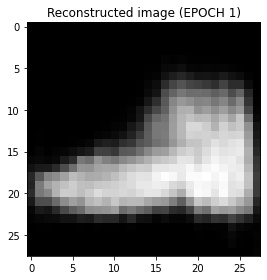

EPOCH 2/50
	 VALIDATION - EPOCH 2/50 - loss: 0.020966


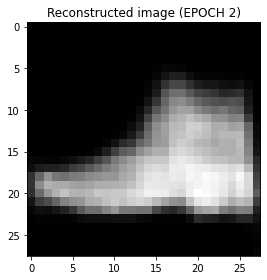

EPOCH 3/50
	 VALIDATION - EPOCH 3/50 - loss: 0.019049


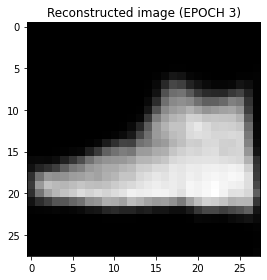

EPOCH 4/50
	 VALIDATION - EPOCH 4/50 - loss: 0.018056


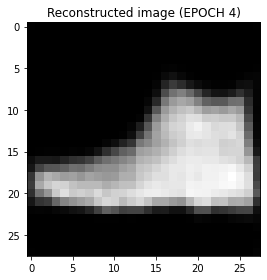

EPOCH 5/50
	 VALIDATION - EPOCH 5/50 - loss: 0.017426


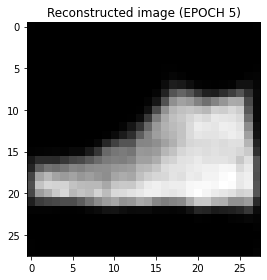

EPOCH 6/50
	 VALIDATION - EPOCH 6/50 - loss: 0.017126


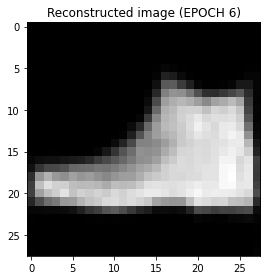

EPOCH 7/50
	 VALIDATION - EPOCH 7/50 - loss: 0.016623


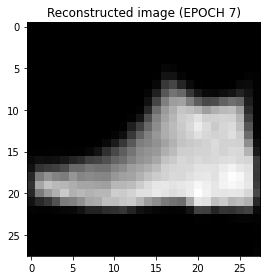

EPOCH 8/50
	 VALIDATION - EPOCH 8/50 - loss: 0.016438


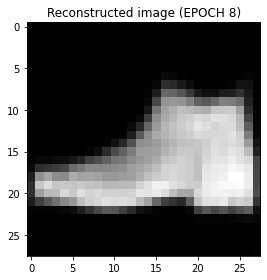

EPOCH 9/50
	 VALIDATION - EPOCH 9/50 - loss: 0.017131


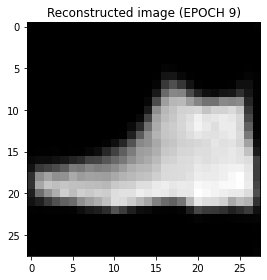

EPOCH 10/50
	 VALIDATION - EPOCH 10/50 - loss: 0.015891


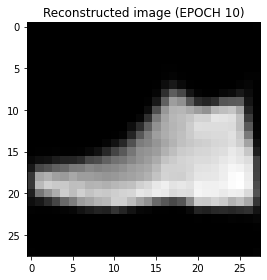

EPOCH 11/50
	 VALIDATION - EPOCH 11/50 - loss: 0.016436


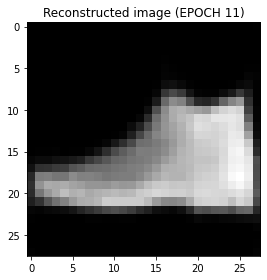

EPOCH 12/50
	 VALIDATION - EPOCH 12/50 - loss: 0.016045


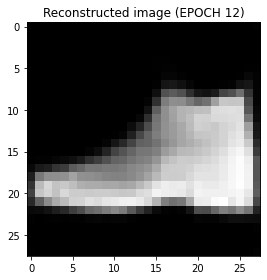

EPOCH 13/50
	 VALIDATION - EPOCH 13/50 - loss: 0.015536


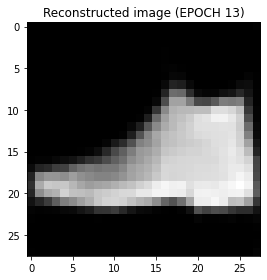

EPOCH 14/50
	 VALIDATION - EPOCH 14/50 - loss: 0.015621


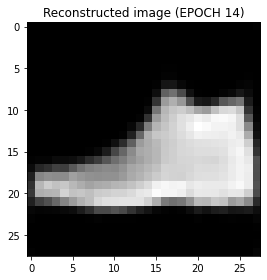

EPOCH 15/50
	 VALIDATION - EPOCH 15/50 - loss: 0.015665


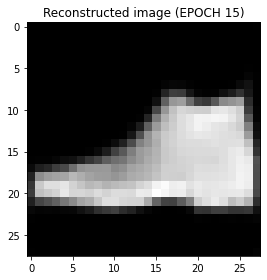

EPOCH 16/50
	 VALIDATION - EPOCH 16/50 - loss: 0.015303


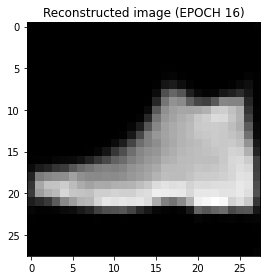

EPOCH 17/50
	 VALIDATION - EPOCH 17/50 - loss: 0.015180


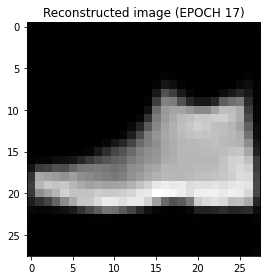

EPOCH 18/50
	 VALIDATION - EPOCH 18/50 - loss: 0.015109


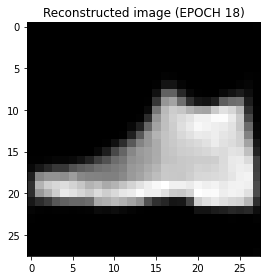

EPOCH 19/50
	 VALIDATION - EPOCH 19/50 - loss: 0.015093


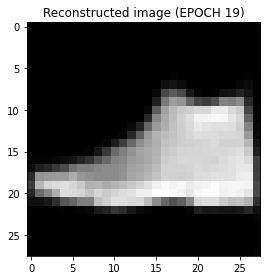

EPOCH 20/50
	 VALIDATION - EPOCH 20/50 - loss: 0.015703


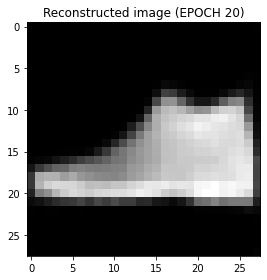

EPOCH 21/50
	 VALIDATION - EPOCH 21/50 - loss: 0.014892


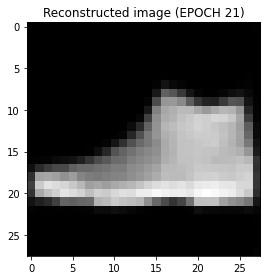

EPOCH 22/50
	 VALIDATION - EPOCH 22/50 - loss: 0.015054


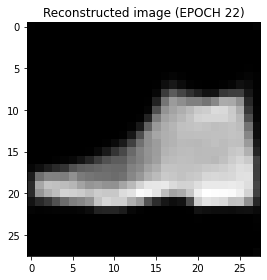

EPOCH 23/50
	 VALIDATION - EPOCH 23/50 - loss: 0.014914


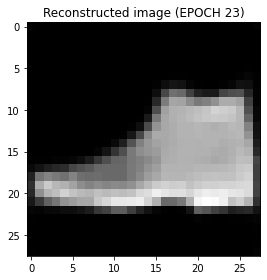

EPOCH 24/50
	 VALIDATION - EPOCH 24/50 - loss: 0.014975


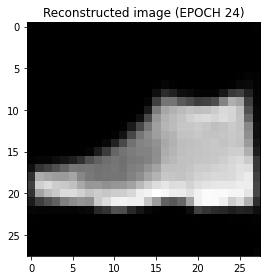

EPOCH 25/50
	 VALIDATION - EPOCH 25/50 - loss: 0.014918


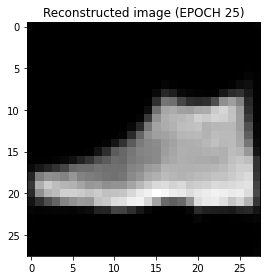

EPOCH 26/50
	 VALIDATION - EPOCH 26/50 - loss: 0.014841


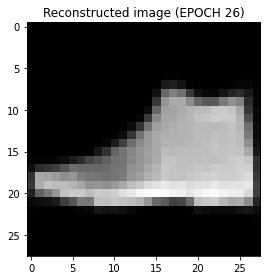

EPOCH 27/50
	 VALIDATION - EPOCH 27/50 - loss: 0.015285


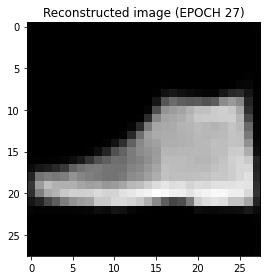

EPOCH 28/50
	 VALIDATION - EPOCH 28/50 - loss: 0.014970


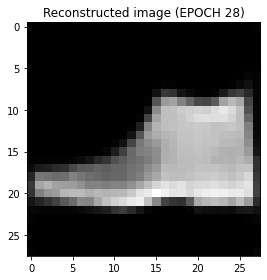

EPOCH 29/50
	 VALIDATION - EPOCH 29/50 - loss: 0.014519


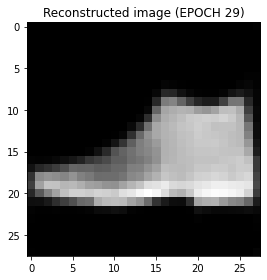

EPOCH 30/50
	 VALIDATION - EPOCH 30/50 - loss: 0.014666


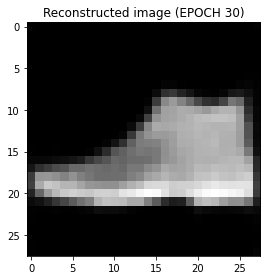

EPOCH 31/50
	 VALIDATION - EPOCH 31/50 - loss: 0.015757


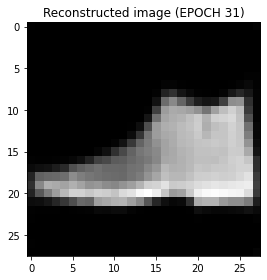

EPOCH 32/50
	 VALIDATION - EPOCH 32/50 - loss: 0.015019


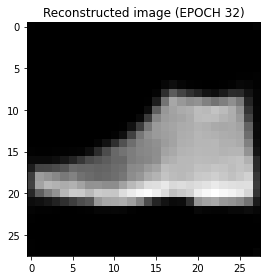

EPOCH 33/50
	 VALIDATION - EPOCH 33/50 - loss: 0.015059


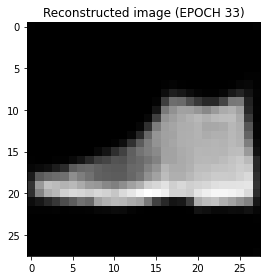

EPOCH 34/50
	 VALIDATION - EPOCH 34/50 - loss: 0.014648


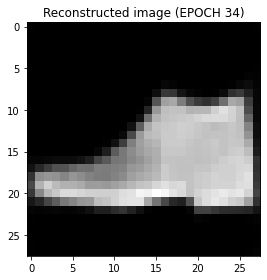

EPOCH 35/50
	 VALIDATION - EPOCH 35/50 - loss: 0.014774


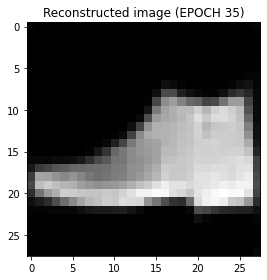

EPOCH 36/50
	 VALIDATION - EPOCH 36/50 - loss: 0.014291


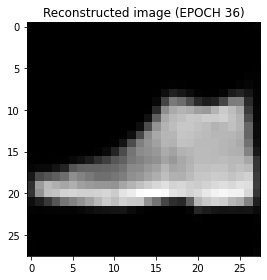

EPOCH 37/50
	 VALIDATION - EPOCH 37/50 - loss: 0.014469


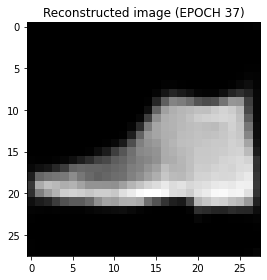

EPOCH 38/50
	 VALIDATION - EPOCH 38/50 - loss: 0.014553


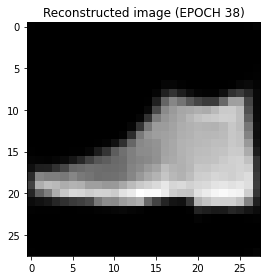

EPOCH 39/50
	 VALIDATION - EPOCH 39/50 - loss: 0.014909


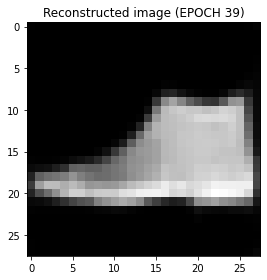

EPOCH 40/50
	 VALIDATION - EPOCH 40/50 - loss: 0.014550


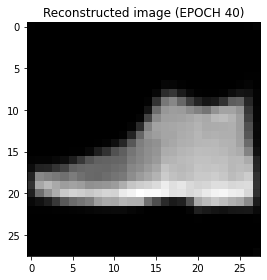

EPOCH 41/50
	 VALIDATION - EPOCH 41/50 - loss: 0.014539


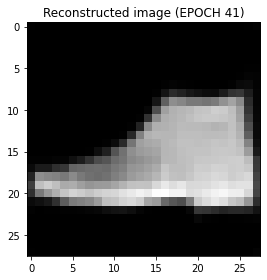

EPOCH 42/50
	 VALIDATION - EPOCH 42/50 - loss: 0.014346


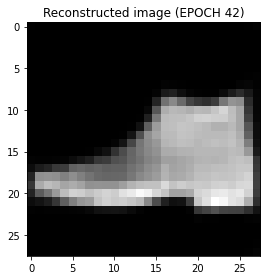

EPOCH 43/50
	 VALIDATION - EPOCH 43/50 - loss: 0.014240


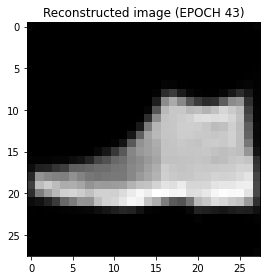

EPOCH 44/50
	 VALIDATION - EPOCH 44/50 - loss: 0.014917


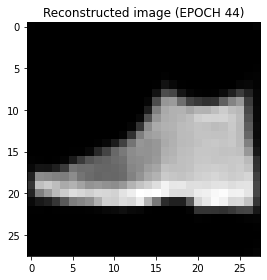

EPOCH 45/50
	 VALIDATION - EPOCH 45/50 - loss: 0.014830


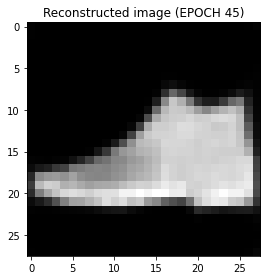

EPOCH 46/50
	 VALIDATION - EPOCH 46/50 - loss: 0.014594


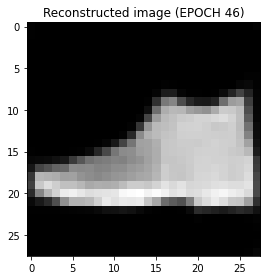

EPOCH 47/50
	 VALIDATION - EPOCH 47/50 - loss: 0.014411


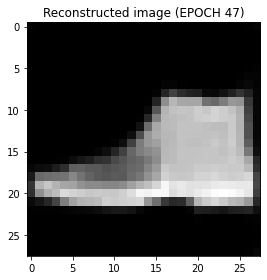

EPOCH 48/50
	 VALIDATION - EPOCH 48/50 - loss: 0.014317


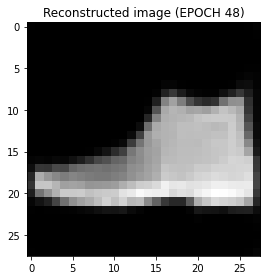

EPOCH 49/50
	 VALIDATION - EPOCH 49/50 - loss: 0.015078


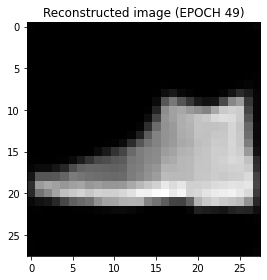

EPOCH 50/50
	 VALIDATION - EPOCH 50/50 - loss: 0.014564


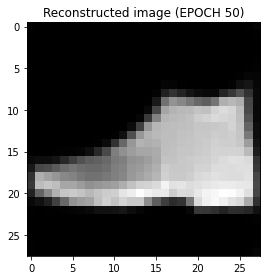

Average Validation Loss over epochs: 0.015649432
########################################


In [109]:
train_losses, val_losses, imgs = training_func(encoder_best, decoder_best, loss_fn, params, training_loader = train_dataloader, testing_loader = test_dataloader, testing_set = test_dataset, verbose = True, plot = False, save = False, save_plot_prog = True)

print("Average Validation Loss over epochs:", np.mean(val_losses))
print("########################################")

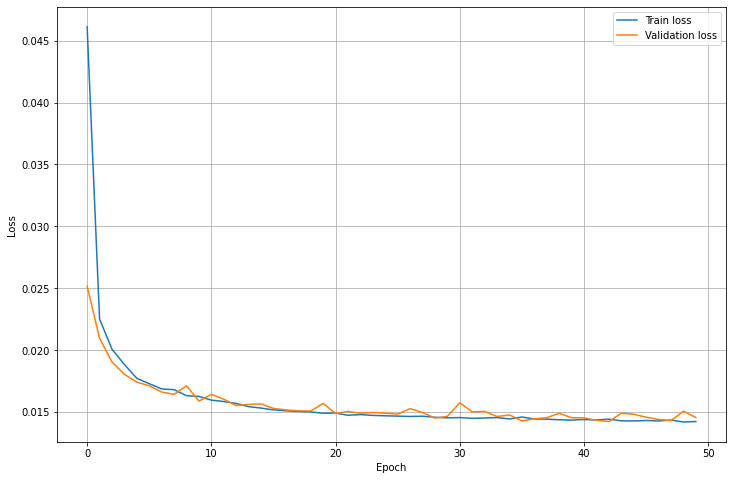

In [110]:
# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

Plot some of the results from this best network

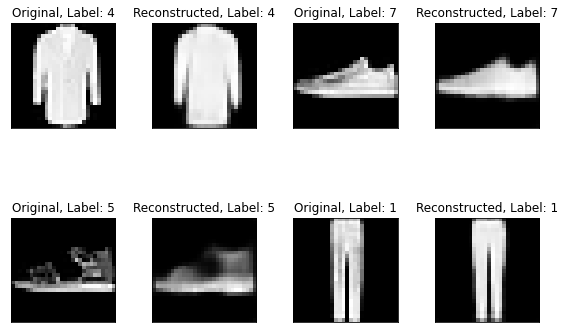

In [111]:
### Plot some samples from test set
fig, axs = plt.subplots(2, 4, figsize=(8,6))

for ax in axs:
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  = encoder_best(img.unsqueeze(0).to(device))
        decoded_img  = decoder_best(encoded_img)
    
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[1].set_title('Reconstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])    
    
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  = encoder_best(img.unsqueeze(0).to(device))
        decoded_img  = decoder_best(encoded_img)
    
    ax[2].imshow(np.array(img1), cmap='gist_gray')
    ax[2].set_title('Original, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    ax[3].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[3].set_title('Reconstructed, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
plt.tight_layout()

In [122]:
#save network
torch.save(encoder_best.state_dict(), 'encoder_params.pth')
torch.save(decoder_best.state_dict(), 'decoder_params.pth')

## Network analysis

In [12]:
# Load network parameters
encoder_best.load_state_dict(torch.load('encoder_params.pth'))
decoder_best.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

Encoded space has 10 variables so we need to reduce the number in order to visually represent them. 

In [14]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder_best.eval()
    with torch.no_grad():
        encoded_img  = encoder_best(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:11<00:00, 842.71it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           -2.770781       -20.726538        28.452658        10.928566   
1           -0.379385         1.718030         4.927734        -7.936980   
2           16.129499       -41.466454        10.026805         5.915218   
3           10.205686       -32.526283         8.491185         1.616091   
4            0.571687         0.971012         3.262577        -6.216164   
...               ...              ...              ...              ...   
9995        -2.598265       -17.229307        25.786045        14.818708   
9996         8.092481       -21.344324         9.834703        -0.966968   
9997        13.592709        -5.186228        23.356457       -15.324536   
9998        10.321061       -32.117275        14.344452         0.813238   
9999         0.268936        -8.091556        16.467405         0.598162   

      Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0            5.282775       -11.165566         2.936369         5.037560   
1            9.033360        -1.273759        -0.867593        -8.528825   
2           -1.593916       -27.144175        10.355828       -37.183601   
3            1.524134       -19.945854         7.952950       -26.912237   
4            4.333203        -2.164788         0.542705        -5.871527   
...               ...              ...              ...              ...   
9995        11.213322        -9.398551        -1.544263         3.907593   
9996         0.610272       -14.827508         6.202915       -20.789137   
9997         1.159858        -7.687561        16.542845       -22.025003   
9998        -1.665008       -21.177057         8.084862       -24.766741   
9999        -1.285661        -6.742191         4.936468        -1.746779   

      Enc. Variable 8  Enc. Variable 9  label  
0           26.592678        13.530088      9  
1           -5.844976         9.697333      2  
2          -19.372017        11.826720      1  
3          -16.764688        11.888822      1  
4           -5.444525         5.724435      6  
...               ...              ...    ...  
9995        23.383093        11.025284      9  
9996       -11.824581        10.095205      1  
9997        11.395924        22.738106      8  
9998       -14.276975        13.086794      1  
9999        13.342720         3.939463      5  

[10000 rows x 11 columns]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


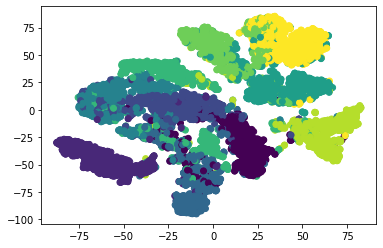

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())
plt.show()

In [82]:
encoded_samples_reduced_TSNE

array([[ 29.99255   ,  73.7945    ],
       [-10.107302  ,  -7.2514267 ],
       [-78.22884   , -29.165054  ],
       ...,
       [ 80.01005   ,  -0.13472572],
       [-64.45415   , -51.48167   ],
       [ 38.709045  ,   7.4833293 ]], dtype=float32)

## Generate new images

In [76]:
def generate_samples(n_samples, model, n_dim):
    decoder_best.eval()
    
    img_list = []
    
    for sample in range(n_samples):
        
        sample_generated = np.random.randint(-75, 75, size = (n_dim))
        #use it as "encoded" data
        encoded_generated = torch.tensor(sample_generated).float().unsqueeze(0).to(device)
        #and now decode it
        # Decode sample
        model.eval()
        with torch.no_grad():
            decoded_generated  = model(encoded_generated)
        img_list.append(decoded_generated.squeeze().cpu().numpy())    
    
    n_cols = 5
    
    if n_samples%n_cols == 0:
        n_rows = n_samples//n_cols
    else:
        n_rows = n_samples//n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize = (8, 8))
    for i, img in enumerate(img_list):
        row = i//n_cols
        col = i%n_cols
        ax[row,col].imshow(img, cmap='gist_gray')
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].set_title("Sample "+str(i+1))
    
    plt.tight_layout()
    plt.show()    
        
    return

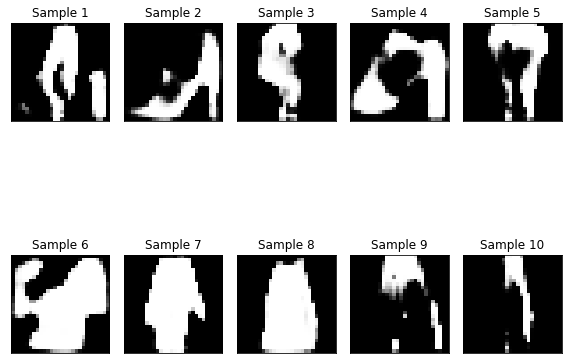

In [79]:
generate_samples(10, decoder_best, 10)#best_set.get('encoded_space_dim'))


Create a classifier. Use a pytorch lightning module which organises and automates code. 

In [35]:
class Classifier(pl.LightningModule):

    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoder = encoder_best 
        self.fine_tune =  nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 10),
            nn.LogSoftmax()
        )
        self.accuracy = torchmetrics.Accuracy()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fine_tune(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        loss = self.loss_fn(z, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx, loss_name='validation_loss'):
        x, y = batch
        z = self.forward(x)
        val_loss = self.loss_fn(z, y)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        self.log('accuracy', self.accuracy(z, y), prog_bar=True)
        return self.accuracy(z, y)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=1e-05)
        return optimizer
    
    def configure_loss(self, loss_fn):
        self.loss_fn = loss_fn

In [22]:
class AE_best(nn.Module):
    def __init__(self):
        super(AE_best, self).__init__()
        self.encoder = encoder_best()
        self.decoder = decoder_best()

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [36]:
#pretrained = encoder_best.load_state_dict(torch.load('encoder_params.pth'))
fine_tune = Classifier(encoded_space_dim)

# Freeze params in the encoder
for param in fine_tune.encoder.parameters():
    param.requires_grad = False

loss_loglike = torch.nn.NLLLoss()
fine_tune.configure_loss(loss_loglike)
fine_tune.to(device)

# Training
trainer = pl.Trainer(max_epochs=30)
trainer.fit(fine_tune, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Encoder    | 38.8 K
1 | fine_tune | Sequential | 1.4 K 
2 | accuracy  | Accuracy   | 0     
3 | loss_fn   | NLLLoss    | 0     
-----------------------------------------
1.4 K     Trainable params
38.8 K    Non-trainable params
40.1 K    Total params
0.161     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Test the accuracy.

In [37]:
trainer.test(fine_tune, test_dataloader)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy            0.7986000180244446
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'accuracy': 0.7986000180244446}]

## Variational AutoEncoder (VAE)


In [53]:
class VariationalEncoder(nn.Module):
    def __init__(self, params):

        super().__init__()
                                                                          
        encoded_space_dim = params['encoded_space_dim']
        n_channels = params['n_channels']
      
        self.encoder = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = n_channels, kernel_size = 3, stride = 2, padding = 1),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels = n_channels, out_channels = 2*n_channels, kernel_size = 3, stride = 2),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels = 2*n_channels, out_channels = 3*n_channels, kernel_size = 3),
                                      nn.ReLU()
                                  )

        #flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(48*n_channels, 64)
        self.fc2 = nn.Linear(64, encoded_space_dim)
        
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.act(self.fc1(x))
        mu =  self.fc2(x)
        sigma = torch.exp(self.fc2(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z 

In [54]:
class Decoder(nn.Module):

    def __init__(self, params):
        super().__init__()
                                         
        encoded_space_dim = params['encoded_space_dim']
        n_channels = params['n_channels']

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=48*n_channels),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(3*n_channels, 4, 4))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            #4-1+3 = 6 x 6
            nn.ConvTranspose2d(in_channels=3*n_channels, out_channels=2*n_channels, kernel_size=3),
            nn.ReLU(True),
            # Second transposed convolution
            #deconv
            #stride(input-1)+kernel-2*padding
            #2(6-1)+3= 13 x 13
            nn.ConvTranspose2d(in_channels=2*n_channels, out_channels=n_channels, kernel_size=3, 
                               stride=2),
            nn.ReLU(True),
            # Third transposed convolution
            #2(13-1)+3-2*1 = 25
            nn.ConvTranspose2d(in_channels=n_channels, out_channels=1, kernel_size=5, 
                               stride=2, padding=1, output_padding=1)
        )
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [55]:
class VariationalAE(nn.Module):
    def __init__(self, params):
        super(VariationalAE, self).__init__()
        self.encoder = VariationalEncoder(params)
        self.decoder = Decoder(params)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [75]:
dummy_params = dict({'encoded_space_dim' : 10, 'n_channels' : 12})

### Initialize the two networks
vae = VariationalAE(dummy_params)


optim = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)

### Define the loss function
loss_func = nn.MSELoss()
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
vae.to(device)

Selected device: cpu


VariationalAE(
  (encoder): VariationalEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (act): ReLU()
    (fc1): Linear(in_features=576, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=576, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(36, 4, 4))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(36, 24, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(24, 12

In [59]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [60]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [61]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

EPOCH: 0
Training loss: 73.50653295084635
Validation loss: 53.36329377441406


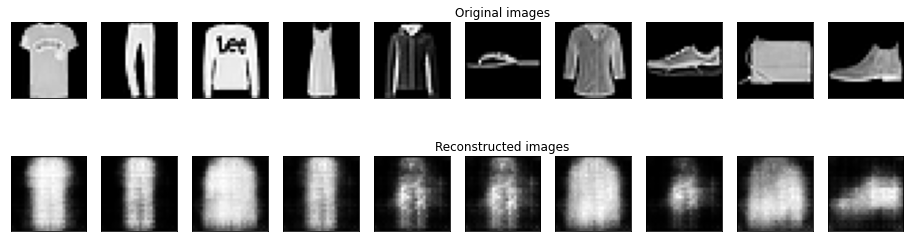

EPOCH: 1
Training loss: 51.065616341145834
Validation loss: 49.141514337158206


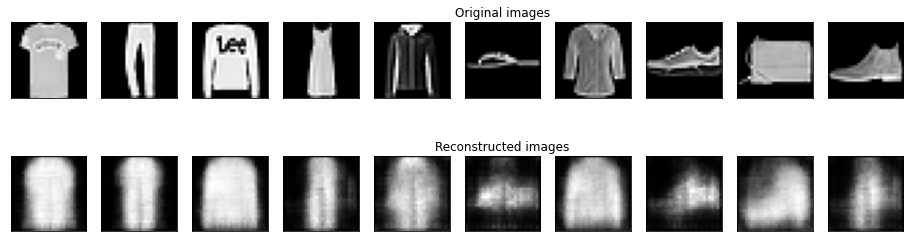

EPOCH: 2
Training loss: 48.24741424153646
Validation loss: 47.33793444824219


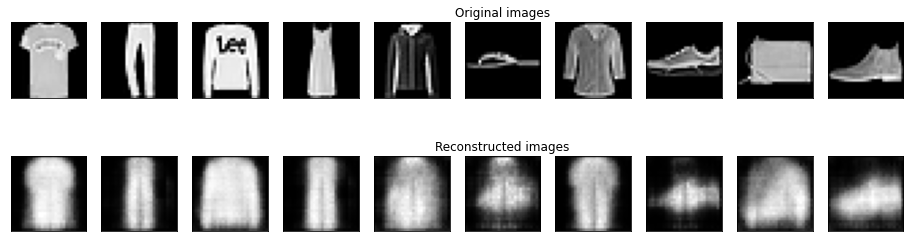

EPOCH: 3
Training loss: 46.20402395833333
Validation loss: 45.19653538818359


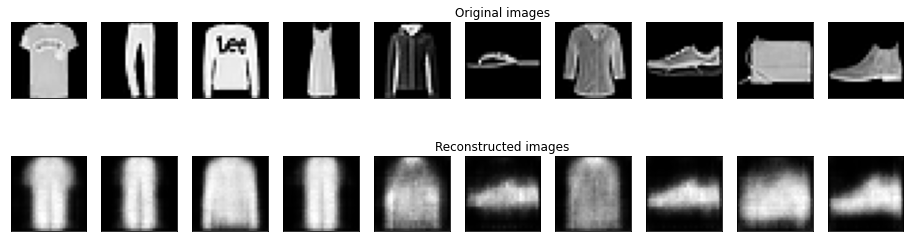

EPOCH: 4
Training loss: 44.92637561848959
Validation loss: 44.199830487060545


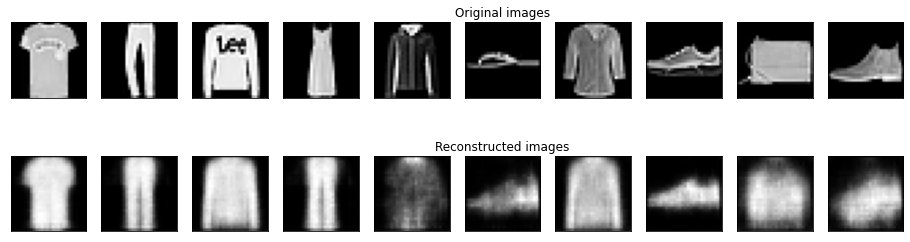

EPOCH: 5
Training loss: 43.99502325846354
Validation loss: 43.435412725830076


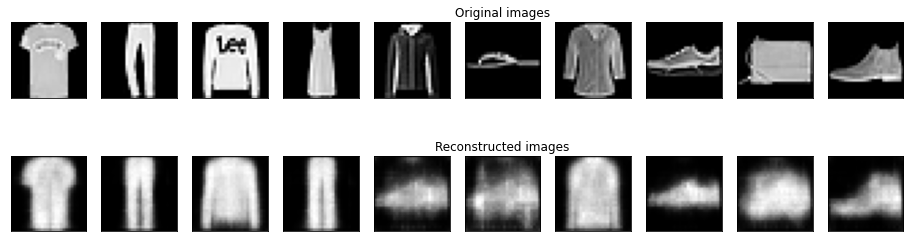

EPOCH: 6
Training loss: 43.12306655273437
Validation loss: 43.942546813964846


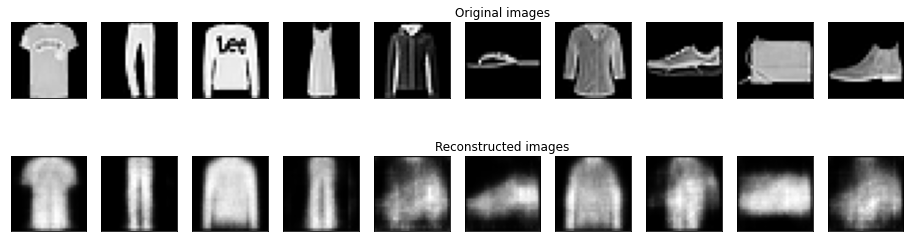

EPOCH: 7
Training loss: 42.49434208984375
Validation loss: 43.089309118652345


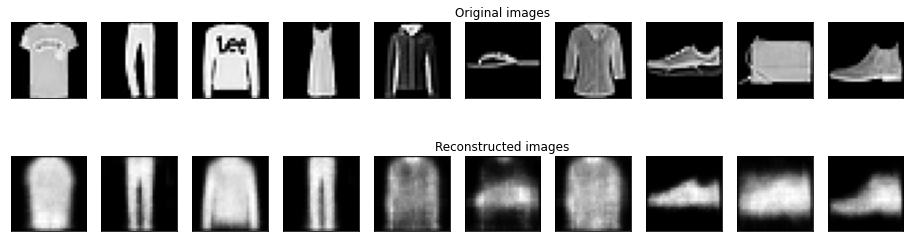

EPOCH: 8
Training loss: 41.90049149983724
Validation loss: 41.722692376708984


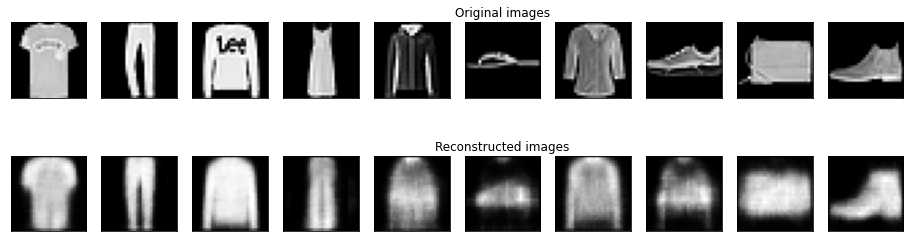

EPOCH: 9
Training loss: 41.604278690592444
Validation loss: 41.593577215576175


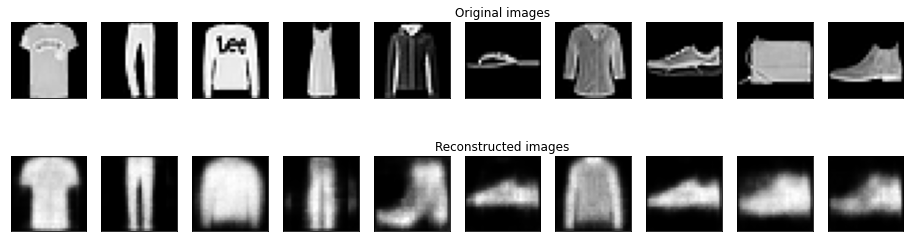

EPOCH: 10
Training loss: 41.220445052083335
Validation loss: 41.14531231689453


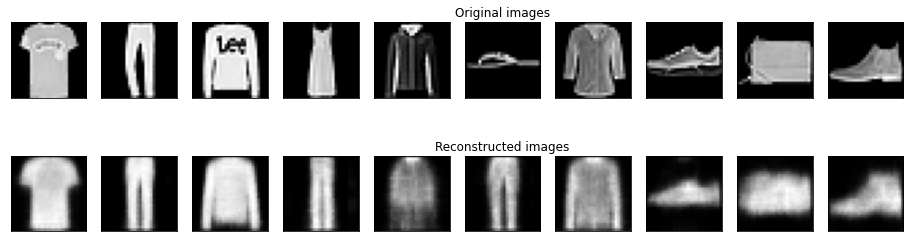

EPOCH: 11
Training loss: 41.0057609375
Validation loss: 40.8460489440918


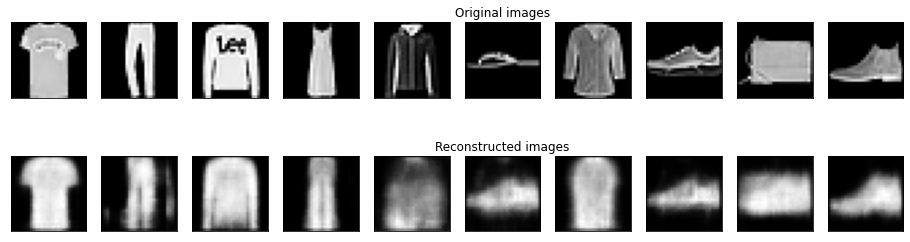

EPOCH: 12
Training loss: 40.800251236979165
Validation loss: 40.78701956176758


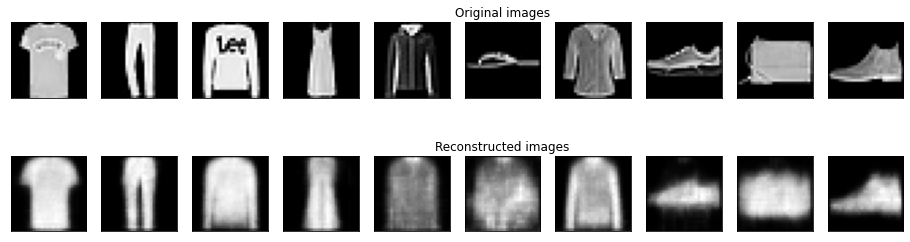

EPOCH: 13
Training loss: 40.63012462565104
Validation loss: 40.76333841552734


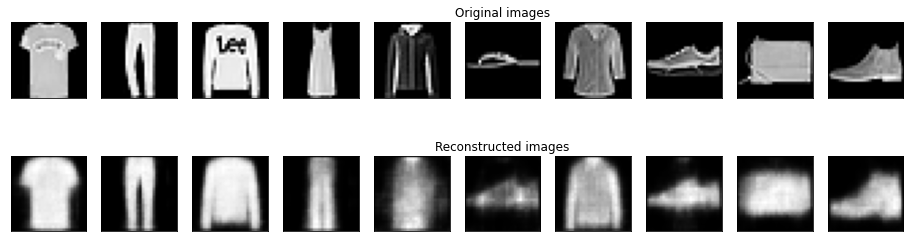

EPOCH: 14
Training loss: 40.48424629313151
Validation loss: 40.35069429321289


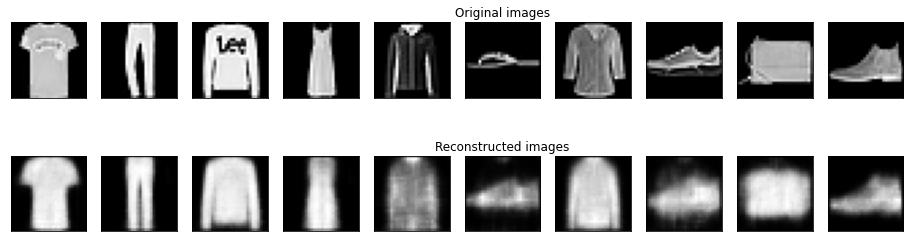

EPOCH: 15
Training loss: 40.336970564778646
Validation loss: 40.253465454101566


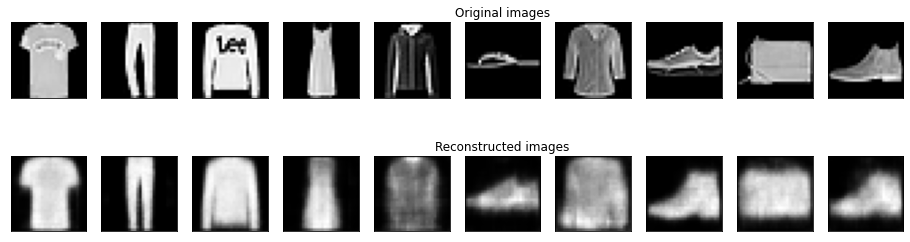

EPOCH: 16
Training loss: 40.182120190429686
Validation loss: 40.43875550537109


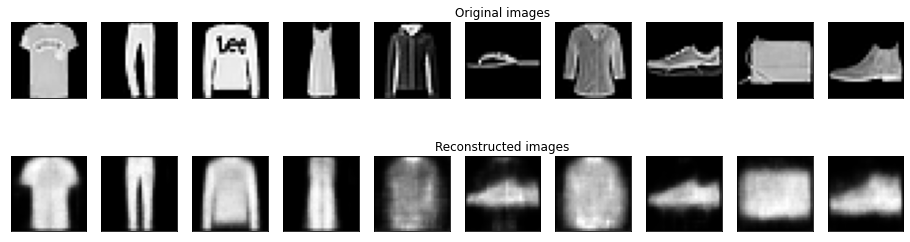

EPOCH: 17
Training loss: 40.002954557291666
Validation loss: 40.37601264648438


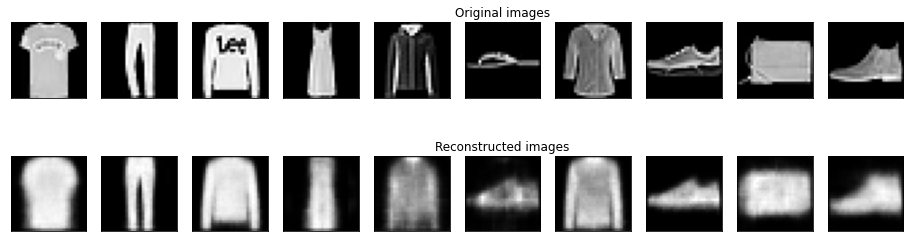

EPOCH: 18
Training loss: 39.9892090250651
Validation loss: 39.88548639526367


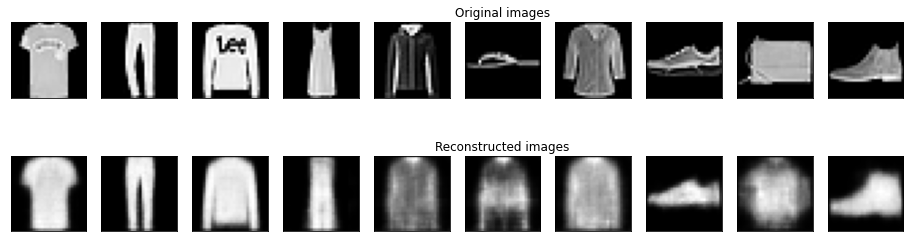

EPOCH: 19
Training loss: 39.95665771484375
Validation loss: 40.02515582275391


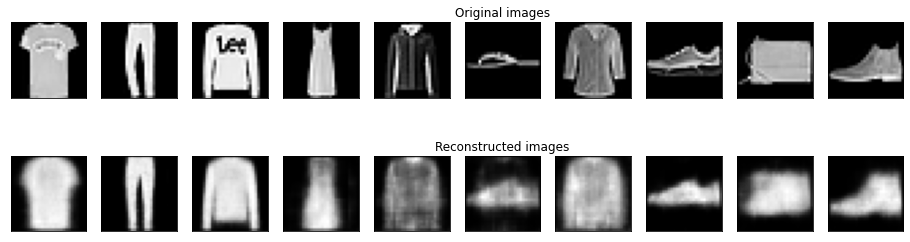

EPOCH: 20
Training loss: 39.83832330322266
Validation loss: 39.8912250793457


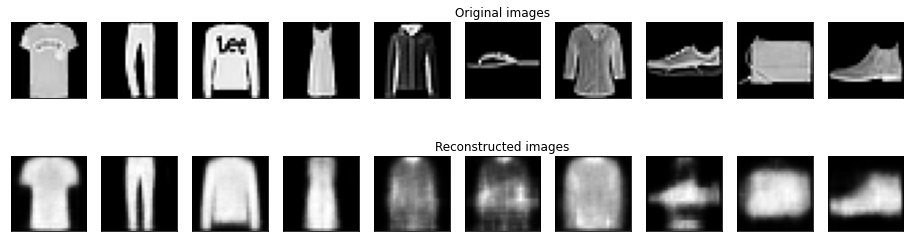

EPOCH: 21
Training loss: 39.69479407552083
Validation loss: 39.56316121826172


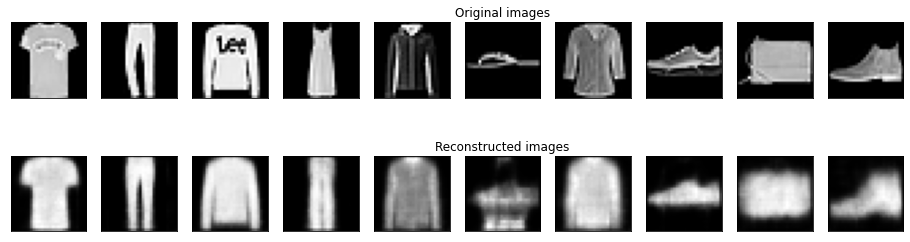

EPOCH: 22
Training loss: 39.6962857421875
Validation loss: 39.56456094970703


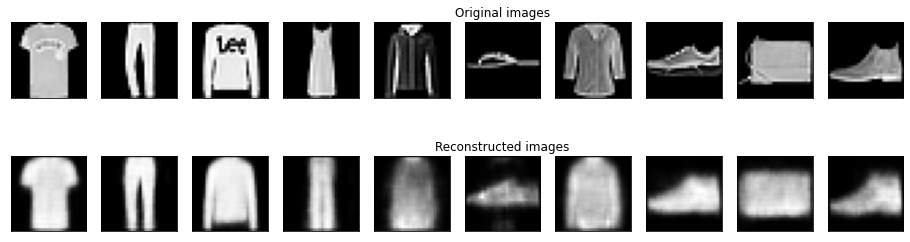

EPOCH: 23
Training loss: 39.59217901204427
Validation loss: 39.775014813232424


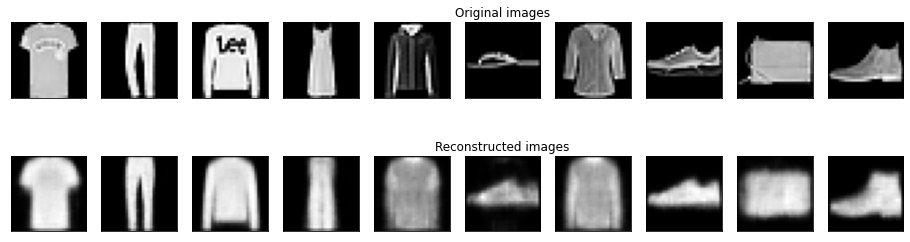

EPOCH: 24
Training loss: 39.58937344563802
Validation loss: 39.56919448852539


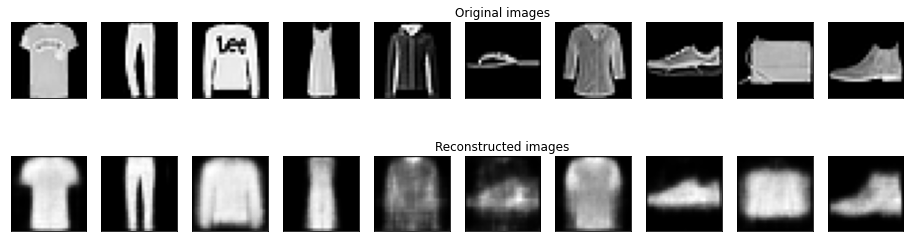

EPOCH: 25
Training loss: 39.53285729980469
Validation loss: 39.50884848632813


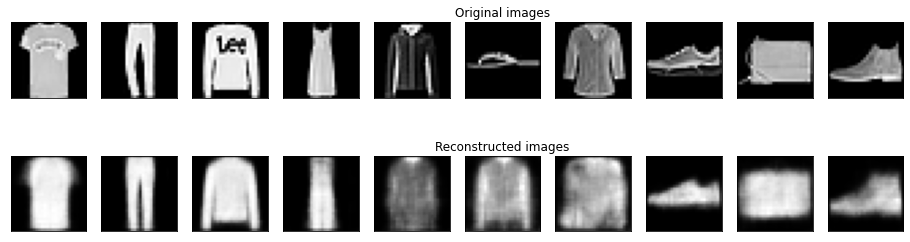

EPOCH: 26
Training loss: 39.45896826985677
Validation loss: 39.33623718261719


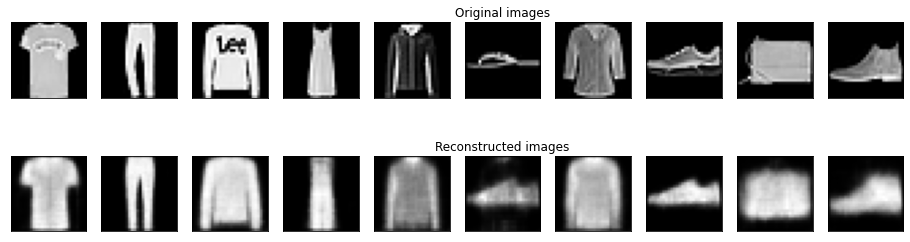

EPOCH: 27
Training loss: 39.41572812093099
Validation loss: 39.35888784179687


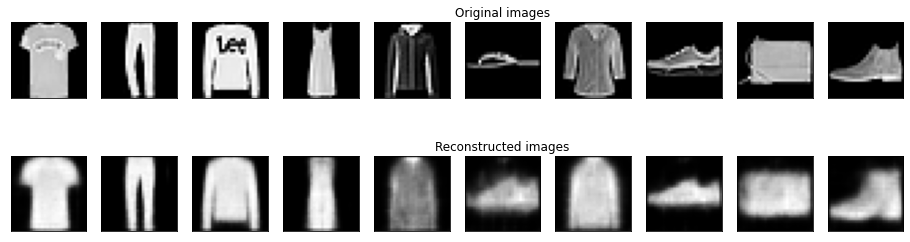

EPOCH: 28
Training loss: 39.37703119303385
Validation loss: 39.22780317382813


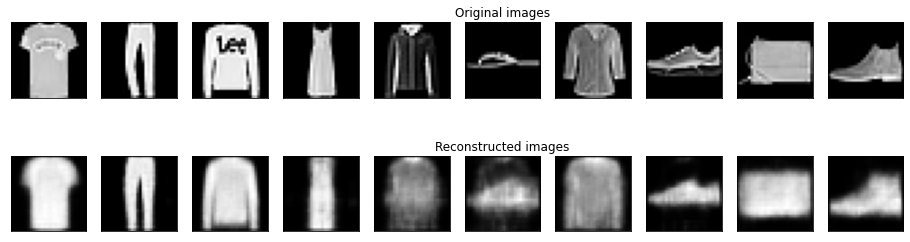

EPOCH: 29
Training loss: 39.29095792643229
Validation loss: 39.29940993652344


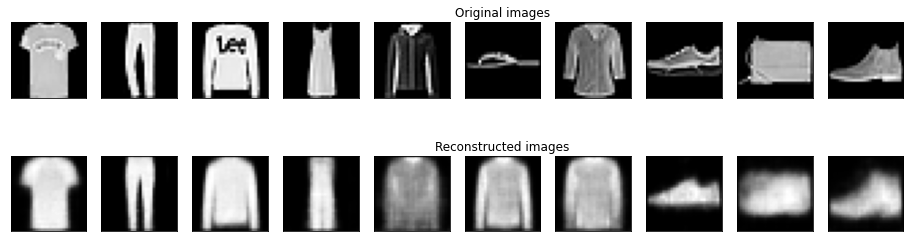

EPOCH: 30
Training loss: 39.3535378540039
Validation loss: 39.25144232177735


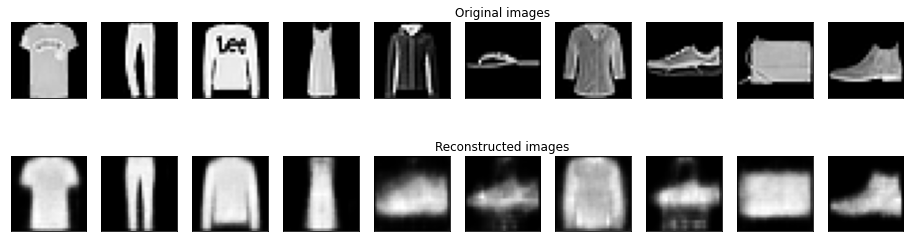

EPOCH: 31
Training loss: 39.31243730875651
Validation loss: 39.208551135253906


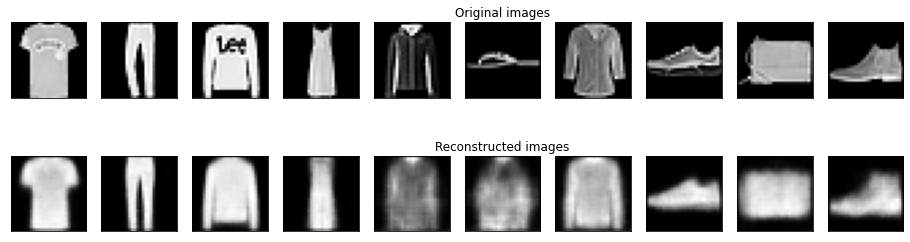

EPOCH: 32
Training loss: 39.268413024902344
Validation loss: 39.39481724243164


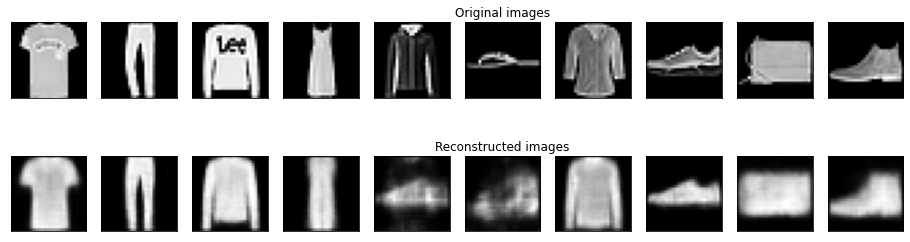

EPOCH: 33
Training loss: 39.23901681315104
Validation loss: 39.55008187255859


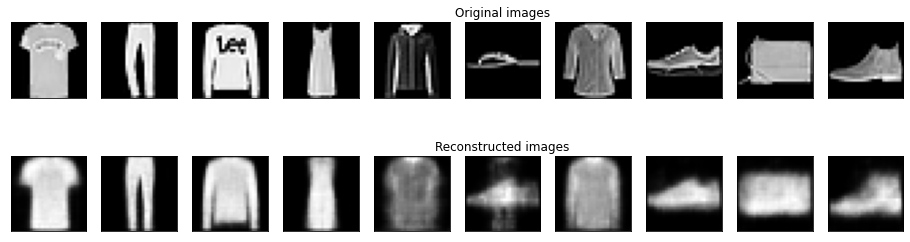

EPOCH: 34
Training loss: 39.16747442220052
Validation loss: 39.221511151123046


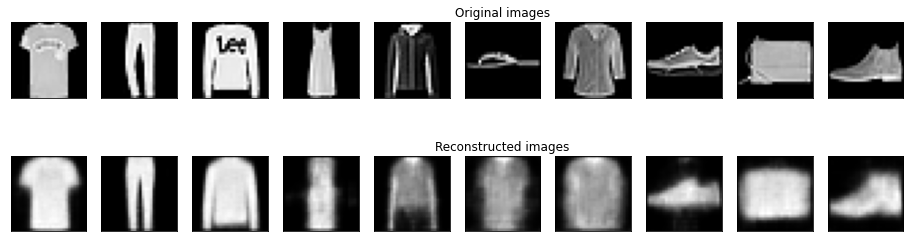

EPOCH: 35
Training loss: 39.136868123372395
Validation loss: 39.105197583007815


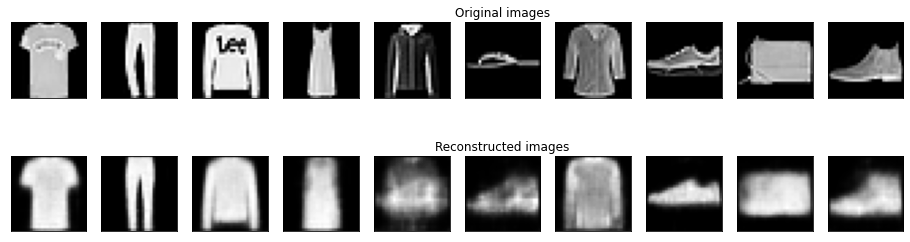

EPOCH: 36
Training loss: 39.05343145345052
Validation loss: 39.077324182128905


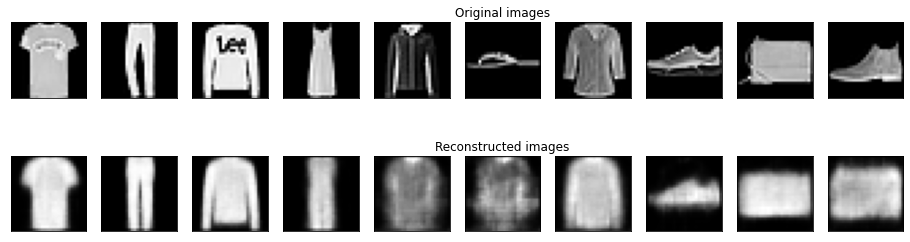

EPOCH: 37
Training loss: 39.11365353190104
Validation loss: 39.09645047607422


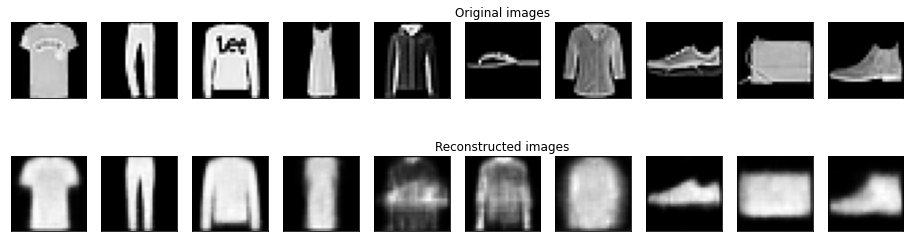

EPOCH: 38
Training loss: 39.08128117675781
Validation loss: 39.17934443359375


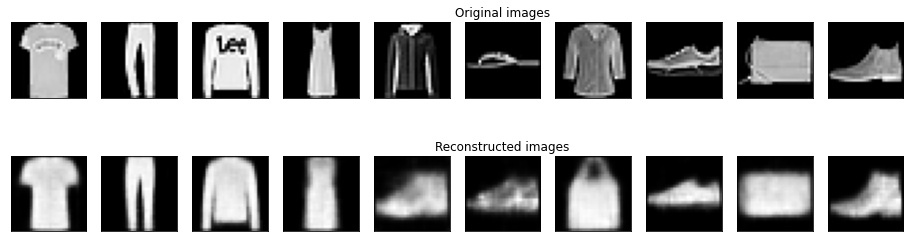

EPOCH: 39
Training loss: 39.0356361328125
Validation loss: 39.598137951660156


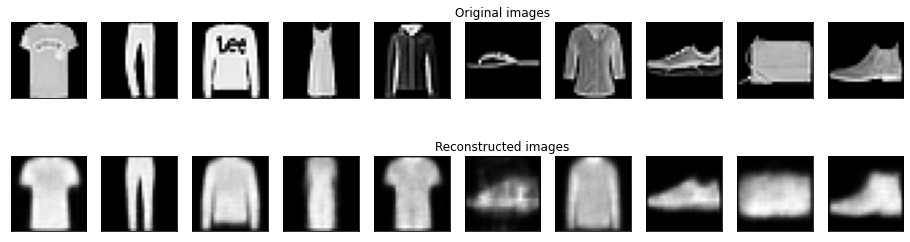

EPOCH: 40
Training loss: 39.008572827148434
Validation loss: 38.960376861572264


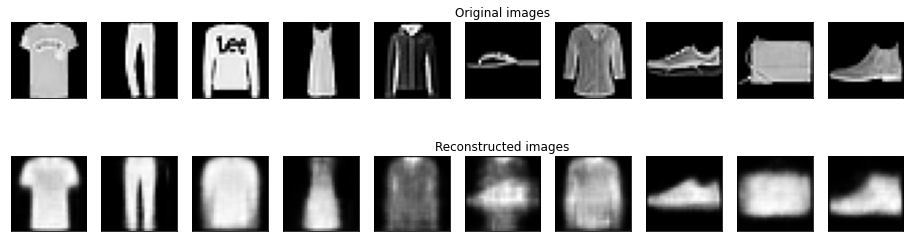

EPOCH: 41
Training loss: 38.945735970052084
Validation loss: 39.07874415893555


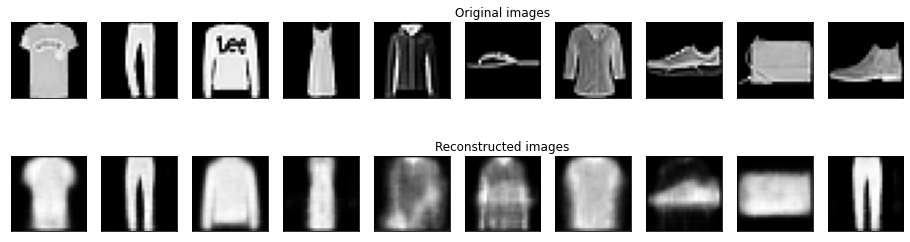

EPOCH: 42
Training loss: 38.964168802897134
Validation loss: 39.20694482421875


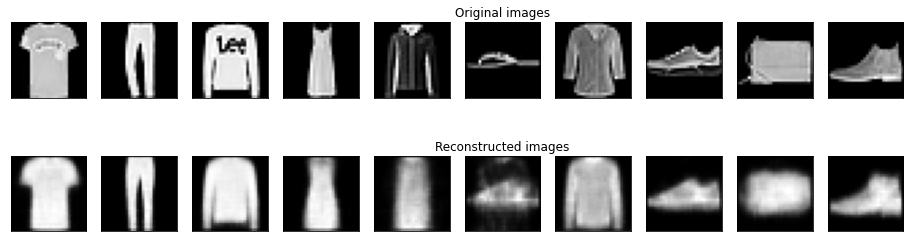

EPOCH: 43
Training loss: 38.98019396158854
Validation loss: 38.81546857910156


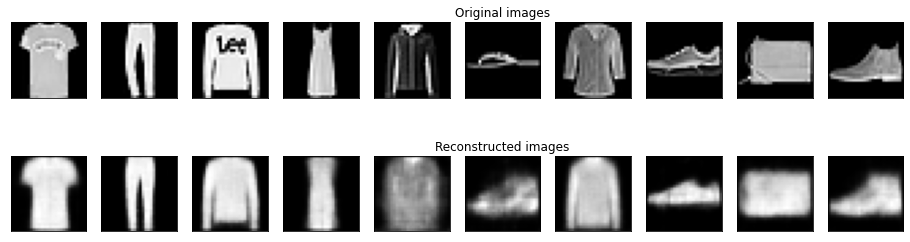

EPOCH: 44
Training loss: 38.917891259765625
Validation loss: 38.95310561523438


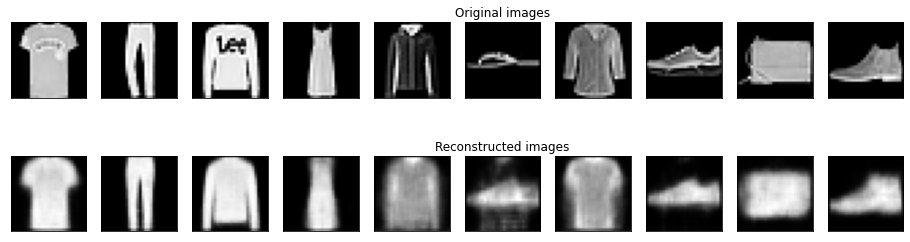

EPOCH: 45
Training loss: 38.84257950032552
Validation loss: 38.972048217773434


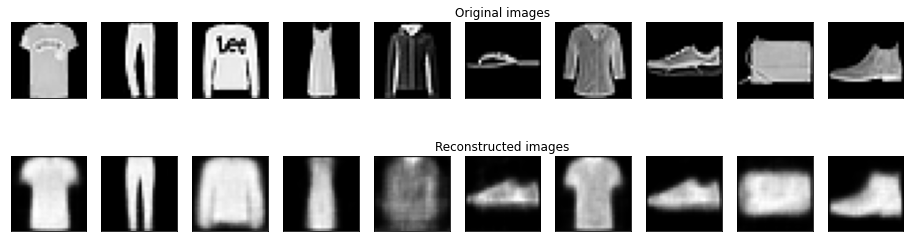

EPOCH: 46
Training loss: 38.823598392740884
Validation loss: 38.855081408691404


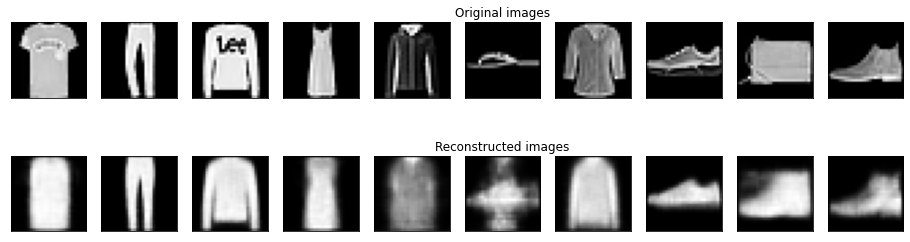

EPOCH: 47
Training loss: 38.82989200846354
Validation loss: 38.807809881591794


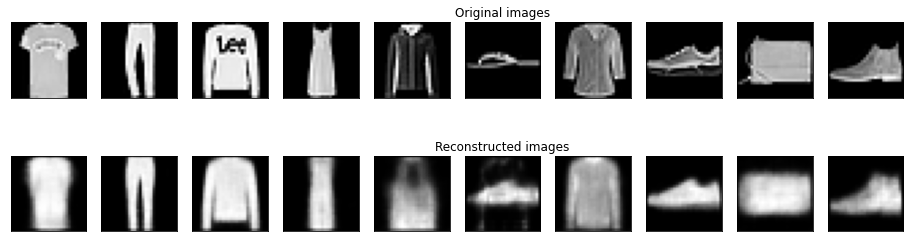

EPOCH: 48
Training loss: 38.77525675455729
Validation loss: 39.05132529296875


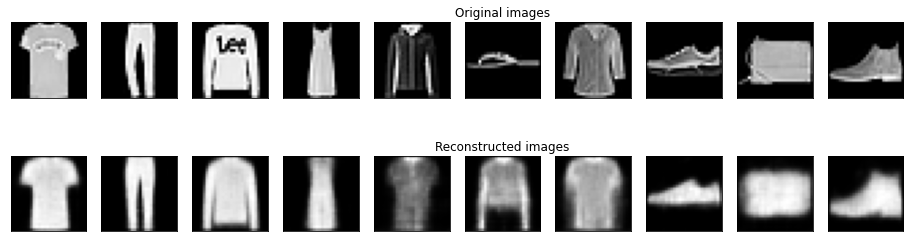

EPOCH: 49
Training loss: 38.76322721761068
Validation loss: 39.01243020019531


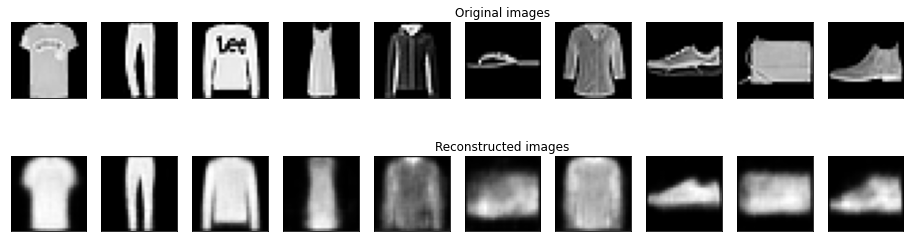

In [83]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
   print("EPOCH:", epoch)
   train_loss = train_epoch(vae,device,train_dataloader,optim)
   print("Training loss:", train_loss)
   train_losses.append(train_loss)
   val_loss = test_epoch(vae,device,test_dataloader)
   print("Validation loss:", val_loss)
   val_losses.append(val_loss)
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)

Plot progression of training model.

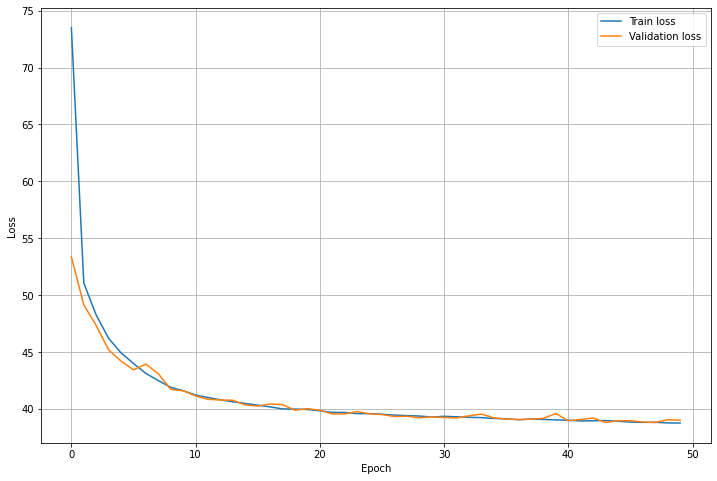

In [84]:
# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

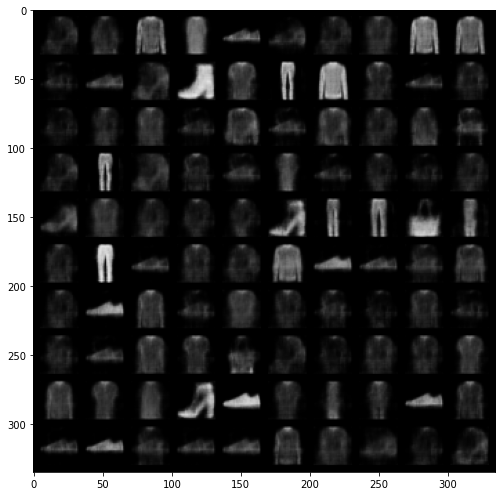

In [104]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoded_space_dim = 10
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(150, encoded_space_dim, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

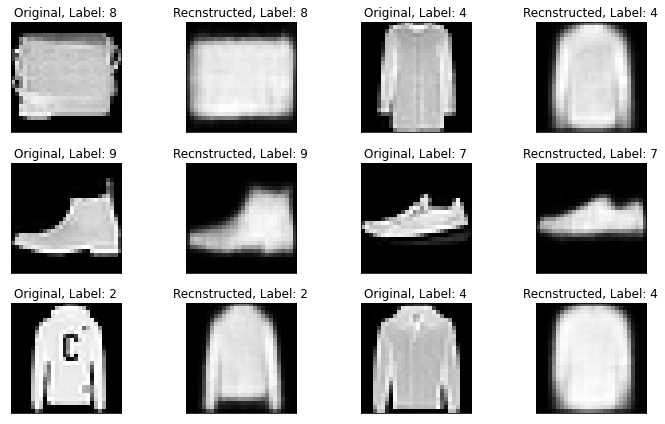

In [87]:
### Plot some sample
fig, axs = plt.subplots(3, 4, figsize=(10,6))
for ax in axs:
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(test_dataset)
    img1 = img[0]
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    img1 = img.unsqueeze(0).to(device)
    vae.eval()
    with torch.no_grad():
        reconstructed = vae(img1)
    ax[1].imshow(np.array(reconstructed.cpu()[0][0]), cmap='gist_gray')
    ax[1].set_title('Recnstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(test_dataset)
    img1 = img[0]
    ax[2].imshow(np.array(img1), cmap='gist_gray')
    ax[2].set_title('Original, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    img1 = img.unsqueeze(0).to(device)
    vae.eval()
    with torch.no_grad():
        reconstructed = vae(img1)
    ax[3].imshow(np.array(reconstructed.cpu()[0][0]), cmap='gist_gray')
    ax[3].set_title('Recnstructed, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
plt.tight_layout()

In [88]:

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)


100%|██████████| 10000/10000 [00:08<00:00, 1166.54it/s]


torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])


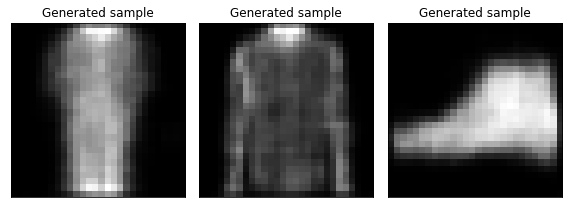

In [103]:
### Generate some samples
fig, ax = plt.subplots(1, 3, figsize=(8,6))

img, label = random.choice(test_dataset)
with torch.no_grad():
    encoded_img  = vae.encoder(img.unsqueeze(0).to(device))
    print(encoded_img.size())
    x = torch.randn_like(encoded_img)
    print(x.size())
    x.to(device)
    decoded_img  = vae.decoder(x)
    print(decoded_img.size())

ax[0].imshow( decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[0].set_title('Generated sample' )
ax[0].set_xticks([])
ax[0].set_yticks([])

with torch.no_grad():
    decoded_img  = vae.decoder(torch.randn_like(encoded_img).to(device) )

ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[1].set_title('Generated sample' )
ax[1].set_xticks([])
ax[1].set_yticks([])

with torch.no_grad():
    decoded_img  = vae.decoder(torch.randn_like(encoded_img).to(device) )

ax[2].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[2].set_title('Generated sample' )
ax[2].set_xticks([])
ax[2].set_yticks([])    
    
plt.tight_layout()

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()